<a href="https://colab.research.google.com/github/YannisZang/CS5864_CV/blob/main/HW2/part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 5864 Homework 2, Part 1: Harris Corner Detector

Implement `extract_keypoints(image)` using k=0.05 and a 5×5 box window. Set `R=0` within 2 px of borders. Return `(x, y, scores, Ix, Iy)`. Visualize on `hokie.jpg` and one other image.

In [ ]:
import numpy as np
import imageio.v3 as iio
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import math

np.random.seed(0)

In [ ]:
HOKIE_PATH = "hokie.jpg"

In [ ]:
def extract_keypoints(image: np.ndarray):
    k = 0.05
    window_size = 5

    img = image.astype(np.float32)
    if img.ndim == 3 and img.shape[2] == 3:
        img_gray = 0.299*img[...,0] + 0.587*img[...,1] + 0.114*img[...,2]
    else:
        img_gray = img

    # TODO: compute Ix and Iy
    Ix = np.zeros_like(img_gray, dtype=np.float32)
    Iy = np.zeros_like(img_gray, dtype=np.float32)

    x_filter = np.array([[-1, 1]])
    y_filter = np.array([[-1],
                        [1]])

    Ix = ndi.convolve(img_gray, x_filter, mode='constant')
    Iy = ndi.convolve(img_gray, y_filter, mode='constant')

    H, W = img_gray.shape
    R = np.zeros((H, W), dtype=np.float32)

    # TODO: compute products Ix^2, Iy^2, IxIy and sum over 5x5 box to form M per pixel
    # TODO: compute R
    # TODO: set R=0 within 2px of image borders

    Ix_squared = Ix**2
    Iy_squared = Iy**2
    IxIy = Ix * Iy

    box = np.zeros((window_size, window_size), dtype=np.float32)

    # Use a box window function. Specifically,
    # all neighbors of (i, j) that are less than half of the window size away
    # should have the same weight (i.e. 1); other neighbors don't contribute.
    for i in range(window_size):
        for j in range(window_size):
           if math.sqrt(abs(i - 2)**2 + abs(j - 2)**2) <= 2.5:
               box[i, j] = 1


    Ix_squared_sum = ndi.convolve(Ix_squared, box, mode='constant')
    Iy_squared_sum = ndi.convolve(Iy_squared, box, mode='constant')
    IxIy_sum = ndi.convolve(IxIy, box, mode='constant')

    # M matrix
    M = np.zeros((H, W, 2, 2), dtype=np.float32)

    for i in range(H):
        for j in range(W):
          M[i, j] = np.array([[Ix_squared_sum[i, j], IxIy_sum[i, j]],
                              [IxIy_sum[i, j], Iy_squared_sum[i, j]]])

    # R
    for i in range(H):
        for j in range(W):
          #  If a pixel is less than 2 pixels from the top/left or 2 pixels from the bottom/right of the image, set its R score to 0 to handle the edge cases
          if i < 2 or i >= H-2 or j < 2 or j >= W-2:
              R[i, j] = 0
          else:
            R[i, j] = M[i, j][0, 0] * M[i, j][1, 1] - M[i, j][0, 1] * M[i, j][1, 0] - k * (M[i, j][0, 0] + M[i, j][1, 1])**2


    # TODO: threshold R to select candidate keypoints
    candidates = np.zeros_like(R, dtype=bool)
    threshold = 5 * np.average(R)
    candidates[R > threshold] = 1

    # TODO: 3x3 non-maximum suppression; discard points without 8 neighbors
    for i in range(H):
      for j in range(W):
        if i == 0 or i == H-1 or j == 0 or j == W-1:
          candidates[i, j] = 0
        elif candidates[i, j] == 1:
          if R[i-1, j-1] >= R[i, j] or R[i-1, j] >= R[i, j]  or R[i-1, j+1] >= R[i, j] or R[i, j-1] >= R[i, j] or R[i, j+1] >= R[i, j] or R[i+1, j-1] >= R[i, j] or R[i+1, j] >= R[i, j] or R[i+1, j+1] >= R[i, j]:
            candidates[i, j] = 0
          else:
            candidates[i, j] = 1
        else:
          continue

    # TODO: return keypoints
    ys, xs = np.nonzero(candidates)
    scores = R[ys, xs]

    return xs.astype(np.int32), ys.astype(np.int32), scores.astype(np.float32), Ix, Iy

## Visualization

In [ ]:
def draw_keypoints(img, x, y, scores, max_points=500):
    img_vis = img
    if img_vis.ndim == 2:
        img_vis = np.stack([img_vis]*3, axis=-1)
    order = np.argsort(-scores)
    order = order[:min(max_points, len(order))]
    xs, ys, ss = x[order], y[order], scores[order]
    plt.figure(figsize=(8, 6))
    plt.imshow(img_vis.astype(np.uint8))
    if len(ss) > 0:
        smin, smax = float(ss.min()), float(ss.max())
    else:
        smin, smax = 0.0, 1.0
    for xi, yi, si in zip(xs, ys, ss):
        r = 3.0 if smax == smin else 3.0 + 7.0 * ((si - smin) / (smax - smin))
        plt.gca().add_patch(Circle((xi, yi), r, fill=False, linewidth=1.0))
    plt.axis('off')
    plt.show()

## Run on `hokie.jpg`

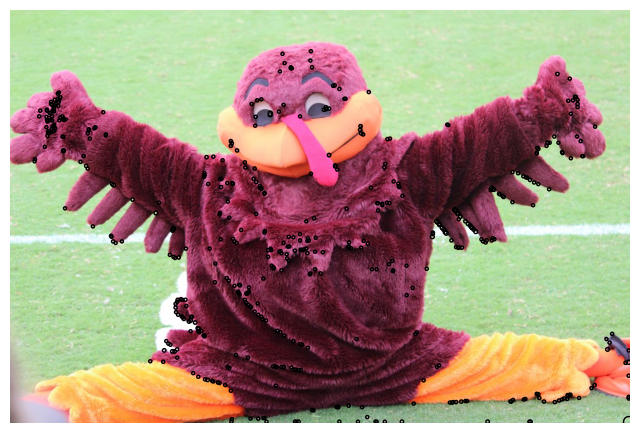

In [ ]:
img = iio.imread(HOKIE_PATH)
x, y, scores, Ix, Iy = extract_keypoints(img)
draw_keypoints(img, x, y, scores)

## Run on another image

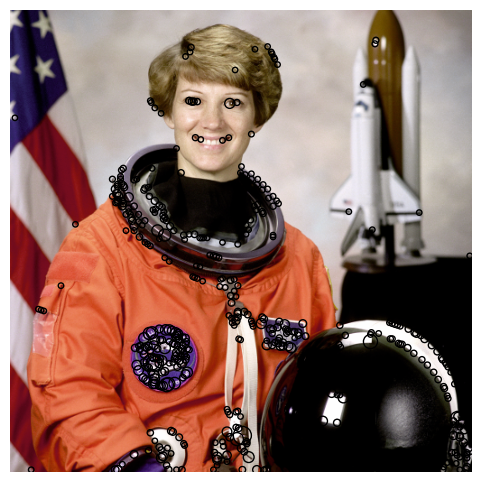

In [ ]:
from skimage import data

# OTHER_IMAGE_PATH = "other.jpg"
# img2 = iio.imread(OTHER_IMAGE_PATH)
img2 = data.astronaut()
x2, y2, scores2, Ix2, Iy2 = extract_keypoints(img2)
draw_keypoints(img2, x2, y2, scores2)

## Checks

In [ ]:
def _check_outputs(img, x, y, scores, Ix, Iy):
    H, W = img.shape[:2]
    assert Ix.shape == (H, W)
    assert Iy.shape == (H, W)
    assert x.ndim == y.ndim == scores.ndim == 1
    assert len(x) == len(y) == len(scores)
    assert x.dtype.kind in 'iu'
    assert y.dtype.kind in 'iu'
    assert scores.dtype.kind in 'f'

_check_outputs(img, x, y, scores, Ix, Iy)